# Day 4: Feature Engineering for Finance
## Week 4: Machine Learning Foundations

---

**Learning Objectives:**
- Create technical indicators as features
- Engineer statistical features
- Handle financial data quirks
- Avoid common pitfalls

In [6]:
# Day 4 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("FEATURE ENGINEERING FOR FINANCE - DAY 4")
print("=" * 60)

FEATURE ENGINEERING FOR FINANCE - DAY 4


## 1. Lagged Returns

LAGGED RETURNS

Created 10 lagged features
            SPY_lag_1  SPY_lag_2  SPY_lag_3  SPY_lag_4  SPY_lag_5  SPY_lag_6  \
Date                                                                           
2019-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2019-01-04  -0.023863        NaN        NaN        NaN        NaN        NaN   
2019-01-07   0.033495  -0.023863        NaN        NaN        NaN        NaN   
2019-01-08   0.007885   0.033495  -0.023863        NaN        NaN        NaN   
2019-01-09   0.009395   0.007885   0.033495  -0.023863        NaN        NaN   

            SPY_lag_7  SPY_lag_8  SPY_lag_9  SPY_lag_10  
Date                                                     
2019-01-03        NaN        NaN        NaN         NaN  
2019-01-04        NaN        NaN        NaN         NaN  
2019-01-07        NaN        NaN        NaN         NaN  
2019-01-08        NaN        NaN        NaN         NaN  
2019-01-09        NaN        NaN        NaN     

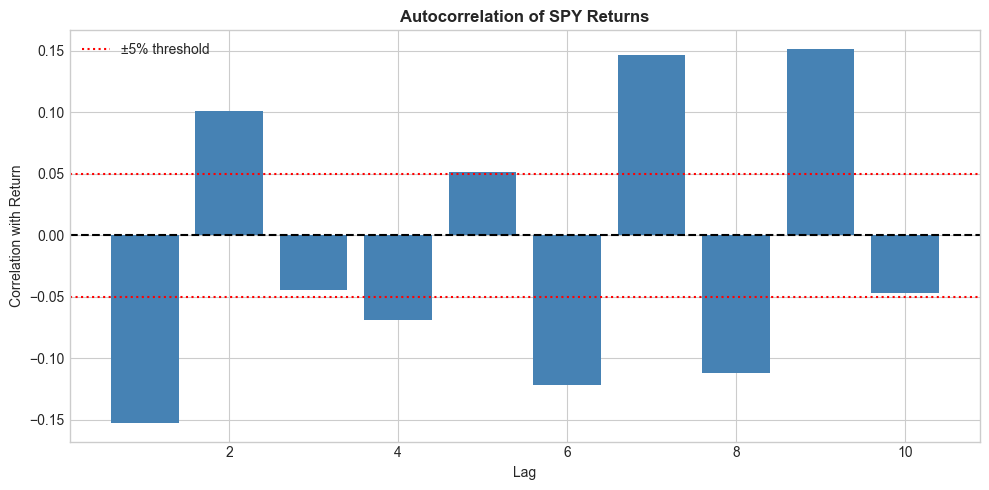


💡 Returns have very weak autocorrelation (markets are efficient!)


In [7]:
# Lagged returns
print("=" * 60)
print("LAGGED RETURNS")
print("=" * 60)

def create_lagged_features(df, column, lags):
    """Create lagged features for a column."""
    features = pd.DataFrame(index=df.index)
    for lag in range(1, lags + 1):
        features[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return features

# Create lagged features
spy_returns = returns['SPY']
lagged = create_lagged_features(returns, 'SPY', lags=10)

print(f"\nCreated {lagged.shape[1]} lagged features")
print(lagged.head())

# Check autocorrelation
correlations = [spy_returns.corr(lagged[col]) for col in lagged.columns]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, 11), correlations, color='steelblue')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation with Return')
ax.set_title('Autocorrelation of SPY Returns', fontweight='bold')
ax.axhline(0, color='black', linestyle='--')
ax.axhline(0.05, color='red', linestyle=':', label='±5% threshold')
ax.axhline(-0.05, color='red', linestyle=':')
ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 Returns have very weak autocorrelation (markets are efficient!)")

## 2. Technical Indicators

In [8]:
# Technical indicators
print("=" * 60)
print("TECHNICAL INDICATORS")
print("=" * 60)

def create_technical_features(prices, returns):
    """Create technical indicator features."""
    features = pd.DataFrame(index=prices.index)
    
    # Moving averages
    for window in [5, 10, 20, 50]:
        features[f'sma_{window}'] = prices.rolling(window).mean()
        features[f'sma_ratio_{window}'] = prices / prices.rolling(window).mean() - 1
    
    # Exponential moving average
    for span in [12, 26]:
        features[f'ema_{span}'] = prices.ewm(span=span).mean()
    
    # MACD
    features['macd'] = prices.ewm(span=12).mean() - prices.ewm(span=26).mean()
    features['macd_signal'] = features['macd'].ewm(span=9).mean()
    features['macd_hist'] = features['macd'] - features['macd_signal']
    
    # Bollinger Bands
    bb_window = 20
    bb_mean = prices.rolling(bb_window).mean()
    bb_std = prices.rolling(bb_window).std()
    features['bb_upper'] = bb_mean + 2 * bb_std
    features['bb_lower'] = bb_mean - 2 * bb_std
    features['bb_position'] = (prices - features['bb_lower']) / (features['bb_upper'] - features['bb_lower'])
    
    # RSI
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    features['rsi'] = 100 - (100 / (1 + rs))
    
    # Momentum
    for period in [5, 10, 20]:
        features[f'momentum_{period}'] = prices.pct_change(period)
    
    # Volatility
    for window in [5, 10, 20]:
        features[f'volatility_{window}'] = returns.rolling(window).std()
    
    # Volume proxy: absolute returns
    features['abs_return'] = returns.abs()
    features['abs_return_5d'] = features['abs_return'].rolling(5).mean()
    
    return features

# Create features for SPY
tech_features = create_technical_features(prices['SPY'], returns['SPY'])

print(f"\nCreated {tech_features.shape[1]} technical features")
print("\nFeature names:")
print(list(tech_features.columns))

TECHNICAL INDICATORS

Created 25 technical features

Feature names:
['sma_5', 'sma_ratio_5', 'sma_10', 'sma_ratio_10', 'sma_20', 'sma_ratio_20', 'sma_50', 'sma_ratio_50', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_lower', 'bb_position', 'rsi', 'momentum_5', 'momentum_10', 'momentum_20', 'volatility_5', 'volatility_10', 'volatility_20', 'abs_return', 'abs_return_5d']


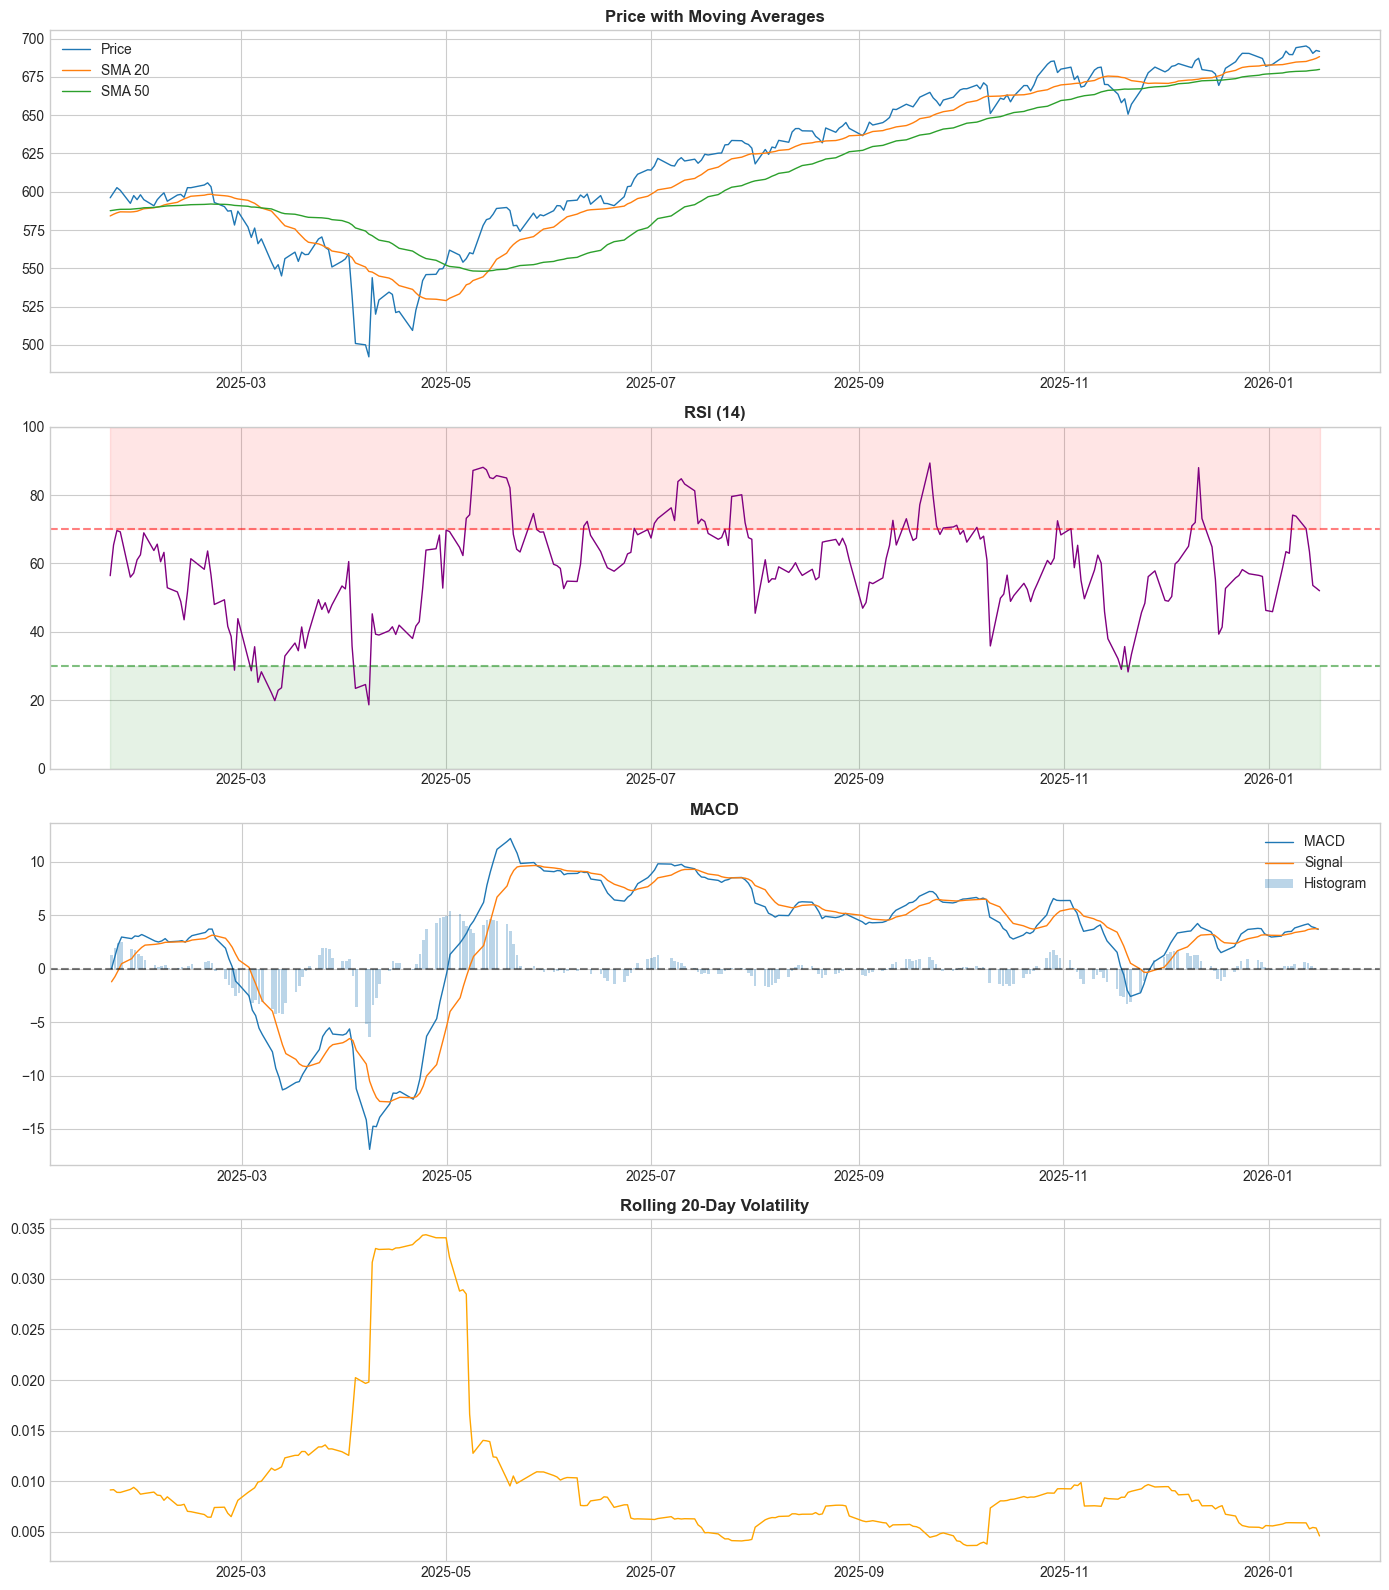

In [9]:
# Visualize some indicators
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Price with moving averages
axes[0].plot(prices['SPY'][-250:], label='Price', lw=1)
axes[0].plot(tech_features['sma_20'][-250:], label='SMA 20', lw=1)
axes[0].plot(tech_features['sma_50'][-250:], label='SMA 50', lw=1)
axes[0].set_title('Price with Moving Averages', fontweight='bold')
axes[0].legend()

# RSI
axes[1].plot(tech_features['rsi'][-250:], lw=1, color='purple')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[1].fill_between(tech_features.index[-250:], 70, 100, alpha=0.1, color='red')
axes[1].fill_between(tech_features.index[-250:], 0, 30, alpha=0.1, color='green')
axes[1].set_title('RSI (14)', fontweight='bold')
axes[1].set_ylim(0, 100)

# MACD
axes[2].plot(tech_features['macd'][-250:], label='MACD', lw=1)
axes[2].plot(tech_features['macd_signal'][-250:], label='Signal', lw=1)
axes[2].bar(tech_features.index[-250:], tech_features['macd_hist'][-250:].values, 
            alpha=0.3, label='Histogram')
axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('MACD', fontweight='bold')
axes[2].legend()

# Volatility
axes[3].plot(tech_features['volatility_20'][-250:], lw=1, color='orange')
axes[3].set_title('Rolling 20-Day Volatility', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Cross-Asset Features

In [14]:
# Cross-asset features
print("=" * 60)
print("CROSS-ASSET FEATURES")
print("=" * 60)

def create_cross_asset_features(returns, target_asset):
    """Create features from other assets."""
    features = pd.DataFrame(index=returns.index)
    
    other_assets = [col for col in returns.columns if col != target_asset]
    
    for asset in other_assets:
        # Lagged returns of other assets
        for lag in [1, 2, 5]:
            features[f'{asset}_lag_{lag}'] = returns[asset].shift(lag)
        
        # Rolling correlations
        features[f'{asset}_corr_20'] = returns[target_asset].rolling(20).corr(returns[asset]).shift(1)
        
        # Relative strength
        features[f'{asset}_rel_strength'] = (
            returns[target_asset].rolling(20).mean() - 
            returns[asset].rolling(20).mean()
        ).shift(1)
    
    # Market breadth (how many assets are up)
    features['market_breadth'] = (returns[other_assets] > 0).sum(axis=1).shift(1) / len(other_assets)
    
    # Average market return
    features['market_avg'] = returns[other_assets].mean(axis=1).shift(1)
    
    return features

cross_features = create_cross_asset_features(returns, 'AAPL')

print(f"\nCreated {cross_features.shape[1]} cross-asset features")
print("\nSample features:")
print(list(cross_features.columns)[:10])

CROSS-ASSET FEATURES

Created 17 cross-asset features

Sample features:
['MSFT_lag_1', 'MSFT_lag_2', 'MSFT_lag_5', 'MSFT_corr_20', 'MSFT_rel_strength', 'SPY_lag_1', 'SPY_lag_2', 'SPY_lag_5', 'SPY_corr_20', 'SPY_rel_strength']


## 4. Complete Feature Pipeline

In [15]:
# Complete feature engineering pipeline
print("=" * 60)
print("COMPLETE FEATURE PIPELINE")
print("=" * 60)

def build_feature_matrix(prices, returns, target_asset, max_lag=5):
    """Build complete feature matrix."""
    features = pd.DataFrame(index=prices.index)
    
    # 1. Lagged returns
    for lag in range(1, max_lag + 1):
        features[f'return_lag_{lag}'] = returns[target_asset].shift(lag)
    
    # 2. Technical indicators (simplified)
    p = prices[target_asset]
    r = returns[target_asset]
    
    # Moving averages
    for w in [5, 10, 20]:
        features[f'sma_ratio_{w}'] = (p / p.rolling(w).mean() - 1).shift(1)
    
    # Volatility
    for w in [5, 10, 20]:
        features[f'vol_{w}'] = r.rolling(w).std().shift(1)
    
    # RSI
    delta = p.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['rsi'] = (100 - (100 / (1 + gain / loss))).shift(1)
    
    # Momentum
    features['momentum_5'] = p.pct_change(5).shift(1)
    features['momentum_20'] = p.pct_change(20).shift(1)
    
    # 3. Cross-asset features
    other_assets = [col for col in returns.columns if col != target_asset]
    for asset in other_assets[:3]:  # Limit to 3
        features[f'{asset}_lag_1'] = returns[asset].shift(1)
    
    # Market average
    features['market_avg'] = returns[other_assets].mean(axis=1).shift(1)
    
    # Target
    target = returns[target_asset]
    
    # Combine and clean
    data = features.join(target.rename('target'))
    data = data.dropna()
    
    X = data.drop('target', axis=1)
    y = data['target']
    
    return X, y

# Build features
X, y = build_feature_matrix(prices, returns, 'AAPL')

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

COMPLETE FEATURE PIPELINE

Feature matrix shape: (1750, 18)
Target shape: (1750,)

Features: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'sma_ratio_5', 'sma_ratio_10', 'sma_ratio_20', 'vol_5', 'vol_10', 'vol_20', 'rsi', 'momentum_5', 'momentum_20', 'MSFT_lag_1', 'SPY_lag_1', 'JPM_lag_1', 'market_avg']


In [16]:
# Evaluate model with features
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series CV
tscv = TimeSeriesSplit(n_splits=5)

# Test different models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=10000),
}

print("\nCross-validation results:")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='r2')
    print(f"{name:15}: R² = {scores.mean():.4f} ± {scores.std():.4f}")

# Feature importance from Lasso
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_scaled, y)

importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop features by Lasso coefficient:")
print(importance.head(10).to_string(index=False))

MODEL EVALUATION

Cross-validation results:
Ridge          : R² = -0.0736 ± 0.0540
Lasso          : R² = -0.0008 ± 0.0045

Top features by Lasso coefficient:
     feature  coefficient
return_lag_1          0.0
return_lag_2          0.0
   JPM_lag_1          0.0
   SPY_lag_1          0.0
  MSFT_lag_1          0.0
 momentum_20          0.0
  momentum_5          0.0
         rsi          0.0
      vol_20          0.0
      vol_10          0.0


## 5. Common Pitfalls

In [17]:
# Common pitfalls
print("=" * 60)
print("COMMON PITFALLS TO AVOID")
print("=" * 60)

print("""
⚠️ LOOK-AHEAD BIAS:
   ✗ Using today's data to predict today's return
   ✓ Always shift features by at least 1 period

⚠️ SURVIVORSHIP BIAS:
   ✗ Only using stocks that exist today
   ✓ Include delisted stocks in historical data

⚠️ DATA SNOOPING:
   ✗ Trying many features until one "works"
   ✓ Predefine features, use proper CV

⚠️ OVERFITTING:
   ✗ Using all 100 features you created
   ✓ Use regularization, feature selection

⚠️ SCALING ISSUES:
   ✗ Fitting scaler on all data
   ✓ Fit scaler only on training data

⚠️ MISSING THE SHIFT:
   ✗ features['sma_ratio'] = price / price.rolling(20).mean()
   ✓ features['sma_ratio'] = (price / price.rolling(20).mean()).shift(1)
""")

# Example of look-ahead bias
print("\nExample: Detecting look-ahead bias")
print("-" * 40)

# WRONG: no shift
bad_feature = prices['SPY'] / prices['SPY'].rolling(20).mean()
bad_corr = bad_feature.corr(returns['SPY'])

# CORRECT: with shift
good_feature = (prices['SPY'] / prices['SPY'].rolling(20).mean()).shift(1)
good_corr = good_feature.corr(returns['SPY'])

print(f"Correlation without shift: {bad_corr:.4f} (LOOKS GREAT!)")
print(f"Correlation with shift:    {good_corr:.4f} (reality)")
print("\n⚠️ The 'great' correlation is due to look-ahead bias!")

COMMON PITFALLS TO AVOID

⚠️ LOOK-AHEAD BIAS:
   ✗ Using today's data to predict today's return
   ✓ Always shift features by at least 1 period

⚠️ SURVIVORSHIP BIAS:
   ✗ Only using stocks that exist today
   ✓ Include delisted stocks in historical data

⚠️ DATA SNOOPING:
   ✗ Trying many features until one "works"
   ✓ Predefine features, use proper CV

⚠️ OVERFITTING:
   ✗ Using all 100 features you created
   ✓ Use regularization, feature selection

⚠️ SCALING ISSUES:
   ✗ Fitting scaler on all data
   ✓ Fit scaler only on training data

⚠️ MISSING THE SHIFT:
   ✗ features['sma_ratio'] = price / price.rolling(20).mean()
   ✓ features['sma_ratio'] = (price / price.rolling(20).mean()).shift(1)


Example: Detecting look-ahead bias
----------------------------------------
Correlation without shift: 0.3692 (LOOKS GREAT!)
Correlation with shift:    -0.0492 (reality)

⚠️ The 'great' correlation is due to look-ahead bias!


## 📝 Key Takeaways - Day 4

### Feature Categories:
1. **Lagged returns** - past performance
2. **Technical indicators** - price patterns
3. **Volatility measures** - risk signals
4. **Cross-asset features** - market regime

### Critical Rules:
- **Always shift by 1**: `feature.shift(1)`
- **Scale in pipeline**: fit on train only
- **Less is more**: regularization > more features

### Common Pitfalls:
| Pitfall | Problem | Solution |
|---------|---------|----------|
| Look-ahead | Future data | Shift features |
| Overfitting | Too many features | Regularization |
| Data snooping | Cherry-picking | Predefine features |

### Interview Questions:
- "What features would you use for return prediction?"
- "How do you avoid look-ahead bias?"
- "Why shift technical indicators?"